In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from matplotlib.colors import LinearSegmentedColormap

# II. Behavioural Monitoring

# III. Statistical Analysis

## 1. Kinematics Inference

### Kalman Filter Algorithm

### Raw and Processed Data of Mouse Kinematics on the X-Axis

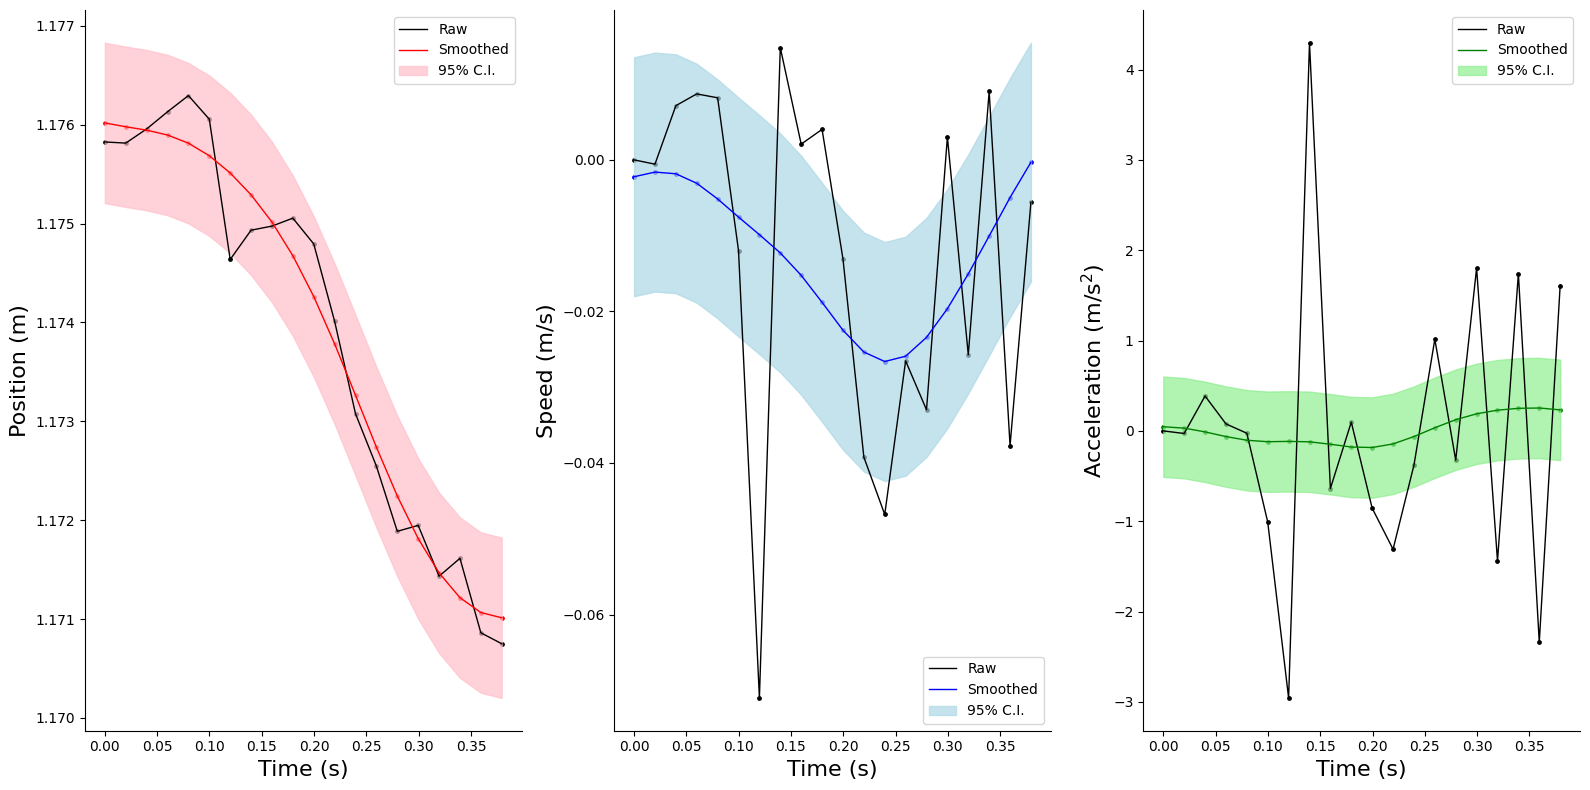

In [2]:
start, end = 10*60*50+2220, 10*60*50+2240
scale = 2e-3

mouse_pos = pd.read_parquet('FigureData/ShortSession0_mousepos.parquet', engine='pyarrow')
dt = (mouse_pos.index[1] - mouse_pos.index[0]).total_seconds()
    
x = mouse_pos.x[start:end] * scale
x_vel = np.array([(x[i+1]-x[i])/dt for i in range(len(x)-1)])
x_vel = np.concatenate((np.array([0]), x_vel))
x_acce = np.array([(x_vel[i+1]-x_vel[i])/dt for i in range(len(x_vel)-1)])
x_acce = np.concatenate((np.array([0]), x_acce))
    
smooth_x = mouse_pos.smoothed_position_x[start:end] * scale
smooth_x_var = mouse_pos.smoothed_position_x_var[start:end] * scale ** 2

smooth_x_vel = mouse_pos.smoothed_velocity_x[start:end] * scale
smooth_x_vel_var = mouse_pos.smoothed_velocity_x_var[start:end] * scale ** 2

smooth_x_acce = mouse_pos.smoothed_acceleration_x[start:end] * scale
smooth_x_acce_var = mouse_pos.smoothed_acceleration_x_var[start:end] * scale ** 2

time = np.arange(0, len(x), 1)
time = time * dt
    
fig, axs = plt.subplots(1,3, figsize = (16,8))

axs[0].set_ylabel('Position (m)', fontsize = 16)
axs[0].plot(time, x, color = 'black', linewidth = 1, label = 'Raw')
axs[0].scatter(time, x, color = 'black', s = 6)
axs[0].plot(time, smooth_x, color = 'red', linewidth = 1, label = 'Smoothed')
axs[0].scatter(time, smooth_x, color = 'red', s = 6)
axs[0].fill_between(time, smooth_x - 1.65*(smooth_x_var**0.5), smooth_x + 1.65*(smooth_x_var**0.5), color = 'pink', alpha = 0.7, label = '95% C.I.')
axs[0].legend(loc = 'upper right')

axs[1].set_ylabel('Speed (m/s)', fontsize = 16)
axs[1].plot(time, x_vel, color = 'black', linewidth = 1, label = 'Raw')
axs[1].scatter(time, x_vel, color = 'black', s = 6)
axs[1].plot(time, smooth_x_vel, color = 'blue', linewidth = 1, label = 'Smoothed')
axs[1].scatter(time, smooth_x_vel, color = 'blue', s=6)
axs[1].fill_between(time, smooth_x_vel - 1.65*(smooth_x_vel_var**0.5), smooth_x_vel + 1.65*(smooth_x_vel_var**0.5), color = 'lightblue', alpha = 0.7, label = '95% C.I.')
axs[1].legend(loc = 'lower right')

axs[2].set_ylabel('Acceleration (m/s$^2$)', fontsize = 16)
axs[2].plot(time, x_acce, color = 'black', linewidth = 1, label = 'Raw')
axs[2].scatter(time, x_acce, color = 'black', s = 6)
axs[2].plot(time, smooth_x_acce, color = 'green', linewidth = 1, label = 'Smoothed')
axs[2].scatter(time, smooth_x_acce, color = 'green', s=6)
axs[2].fill_between(time, smooth_x_acce - 1.65*(smooth_x_acce_var**0.5), smooth_x_acce + 1.65*(smooth_x_acce_var**0.5), color = 'lightgreen', alpha = 0.7, label = '95% C.I.')
axs[2].legend(loc = 'upper right')

for i in range(3):
    axs[i].set_xticks(np.arange(0,time[-1]+0.01, 0.05))
    axs[i].set_xlabel('Time (s)', fontsize = 16)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    
    
plt.tight_layout()
plt.show()

## 2. Foraging Bout Duration Prediction

### Observations and Predictions From the Gaussian-GLM Model

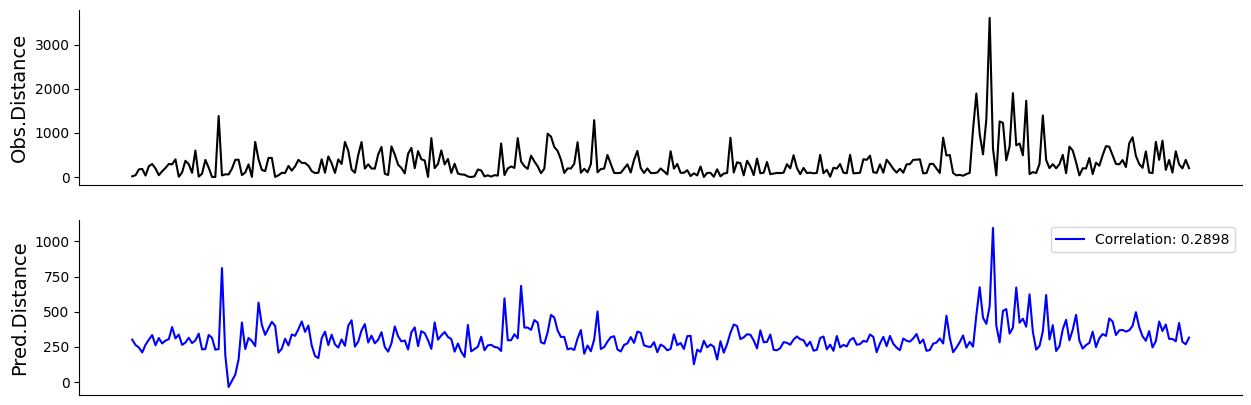

In [36]:
VISIT = pd.read_parquet('FigureData/VISIT.parquet', engine='pyarrow')
feature = ['speed','acceleration', 'PelletsInLastVisitSelf', 'PelletsInLastVisitOther', 'IntervalLastVisit' ,'entry']
predictor = 'distance'

X, Y = VISIT[feature], VISIT[predictor]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index = X.index, columns = X.columns)
X['interc'] = 1

split_size = int(len(Y) * 0.75)
indices = np.arange(len(Y))

MSE = []
MSE_max = 1e10

for i in range(1000):
    np.random.shuffle(indices)
    
    train_indices = indices[:split_size]
    test_indices = indices[split_size:]

    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    Y_train, Y_test = Y.iloc[train_indices], Y.iloc[test_indices]
    
    model = sm.GLM(Y, X, family=sm.families.Gaussian())
    result = model.fit()
    Y_test_pred = result.predict(X_test)
    
    mse = np.mean((Y_test_pred - Y_test) ** 2)
    
    MSE.append(mse)
    
    if mse < MSE_max:  
        result_valid = result
        MSE_max = mse

Y_pred = result.predict(X)


fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
axs[0].plot(Y.to_numpy(), color = 'black')
axs[0].set_xticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('Obs.' + predictor[0].upper() + predictor[1:], fontsize = 14)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].plot(Y_pred.to_numpy(), color = 'blue', label = 'Correlation: '+str(round(np.corrcoef(Y.to_numpy(), Y_pred.to_numpy())[0,1],4)))
axs[1].set_xticks([]) 
axs[1].set_facecolor('white') 
axs[1].set_ylabel('Pred.' + predictor[0].upper() + predictor[1:], fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].legend()

axs[1].set_xticks([0,318],['#1', '#319'])
axs[1].set_xlabel('Single Visits')
    
plt.show()


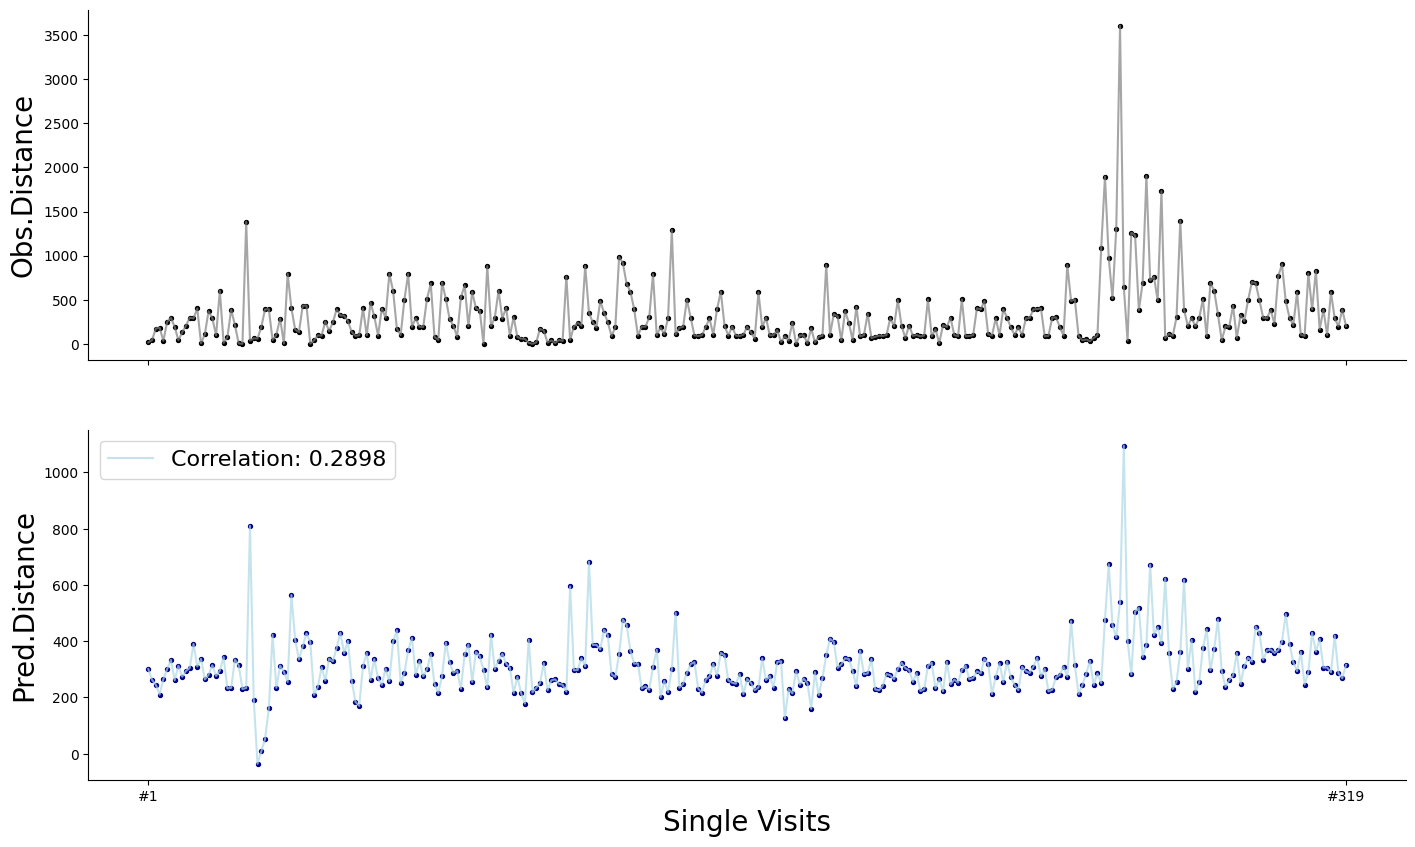

In [57]:
visits = np.arange(0,len(Y.to_numpy()))

fig, axs = plt.subplots(2, 1, figsize=(17, 10), sharex=True)

axs[0].scatter(visits, Y.to_numpy(), s = 8, color = 'black')
axs[0].plot(visits,Y.to_numpy(), color = 'grey', alpha = 0.7)
axs[0].set_xticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('Obs.' + predictor[0].upper() + predictor[1:], fontsize = 20)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].scatter(visits, Y_pred.to_numpy(), s = 8, color = 'darkblue')
axs[1].plot(visits,Y_pred.to_numpy(), color = 'lightblue', alpha = 0.7, label = 'Correlation: '+str(round(np.corrcoef(Y.to_numpy(), Y_pred.to_numpy())[0,1],4)))
axs[1].set_xticks([]) 
axs[1].set_facecolor('white') 
axs[1].set_ylabel('Pred.' + predictor[0].upper() + predictor[1:], fontsize = 20)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].legend(fontsize = 16)

axs[1].set_xticks([0,318],['#1', '#319'])
axs[1].set_xlabel('Single Visits', fontsize = 20)
    
plt.show()

In [4]:
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                  319
Model:                            GLM   Df Residuals:                      312
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                      1.1880e+05
Method:                          IRLS   Log-Likelihood:                -2312.9
Date:                Tue, 09 Apr 2024   Deviance:                   3.7065e+07
Time:                        16:52:51   Pearson chi2:                 3.71e+07
No. Iterations:                     3   Pseudo R-squ. (CS):            0.08601
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed                     

## 3. Behavioural Syllable Characterization

In [29]:
feature = ['smoothed_speed', 'smoothed_acceleration']
color_names = ['black', "blue", "red", "tan", "green", "brown", "purple", "orange", "black", 'turquoise']
state_names = ['Resting', 'Eating', 'Digging', 'Clinging', 'Exploring', 'Fast-Leaving']
alpha = [0.4, 0.4, 0.2, 0.4, 0.7, 0.9]

mouse_pos = pd.read_parquet('FigureData/ShortSession1_mousepos.parquet', engine='pyarrow')
states = np.load('FigureData/States.npy', allow_pickle=True)
mouse_pos['states'] = pd.Series(states, index = mouse_pos.index)

mouse_pos.smoothed_velocity_x = mouse_pos.smoothed_velocity_x * scale
mouse_pos.smoothed_acceleration_x = mouse_pos.smoothed_acceleration_x * scale
mouse_pos.smoothed_speed = mouse_pos.smoothed_speed * scale
mouse_pos.smoothed_acceleration = mouse_pos.smoothed_acceleration * scale


resampled_mouse_pos = mouse_pos.resample('1S').agg({
    'x': 'mean',  
    'y': 'mean',  
    'smoothed_velocity_x':'mean',
    'smoothed_acceleration_x':'mean',
    'smoothed_position_x':'mean',
    'smoothed_position_y':'mean',
    'smoothed_speed':'mean',
    'smoothed_acceleration':'mean',
    'states': lambda x: x.mode()[0] if not x.empty else None
    })

### Choose HMM State Number 
***Not Displayed on Poster***

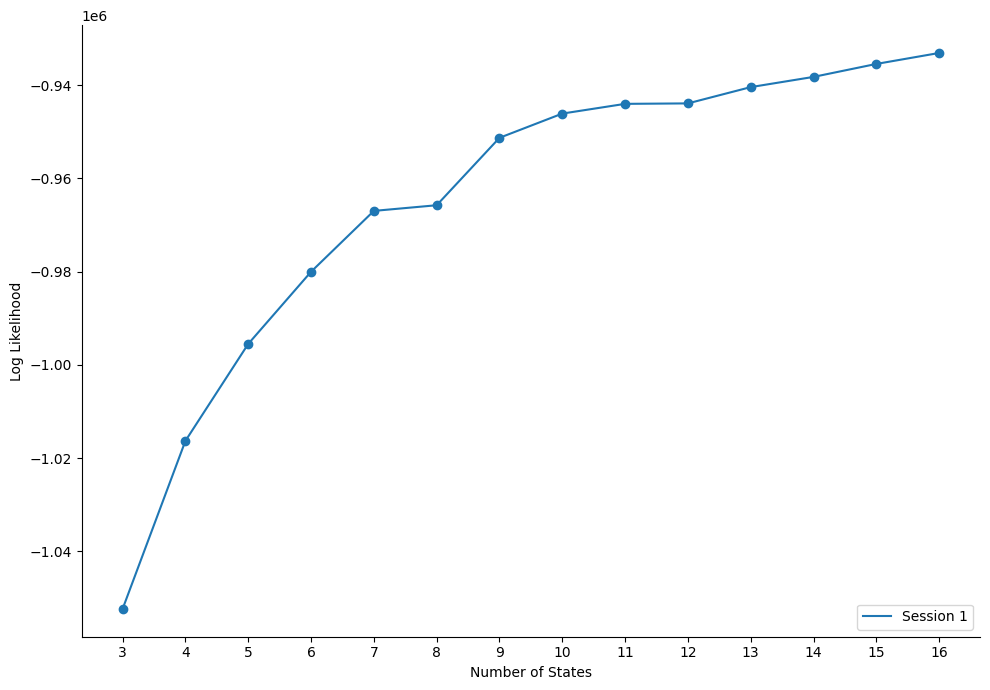

In [6]:
N = np.arange(3,17,1)
LogLikelihood = np.load('FigureData/LogLikelihood.npy', allow_pickle=True)
LogLikelihood = LogLikelihood.item()

fig, axs = plt.subplots(1,1,figsize = (10,7))
for key in LogLikelihood.keys():
    LL = LogLikelihood[key]
    axs.scatter(N, LL)
    axs.plot(N, LL, label = 'Session ' + str(key))
axs.legend(loc = 'lower right')
axs.set_xticks(N)
axs.set_xlabel('Number of States')
axs.set_ylabel('Log Likelihood')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

### Transition Diagram of Characterizd Mouse Syllables

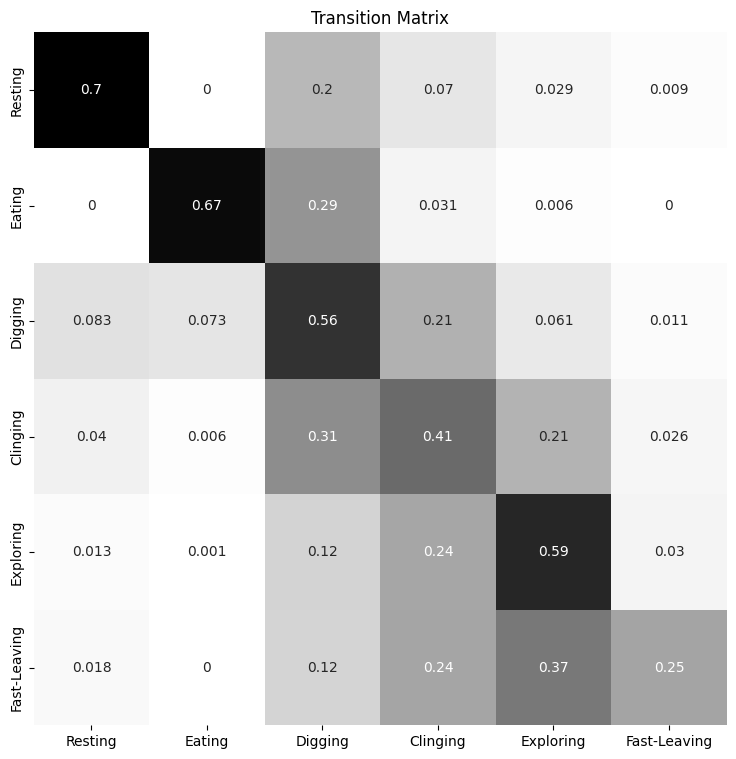

In [7]:
n = 6
TransM = np.zeros((n,n))
states = resampled_mouse_pos.states.to_numpy()
    
for i in range(len(states)-1):
    TransM[states[i]][states[i+1]] += 1
        
for i in range(n):
    TransM[i] = TransM[i]/sum(TransM[i])

annot_array = np.array([[round(item, 3) for item in row] for row in TransM])

fig, axs = plt.subplots(1,1, figsize=(len(TransM)+3, len(TransM)+3))
sns.heatmap(TransM, cmap='binary', ax = axs, square = 'True', cbar = False, annot=annot_array)
axs.set_title("Transition Matrix") 
axs.set_xticklabels(state_names)
axs.set_yticklabels(state_names)
plt.show()

### Mouse Positions in Different Syllables

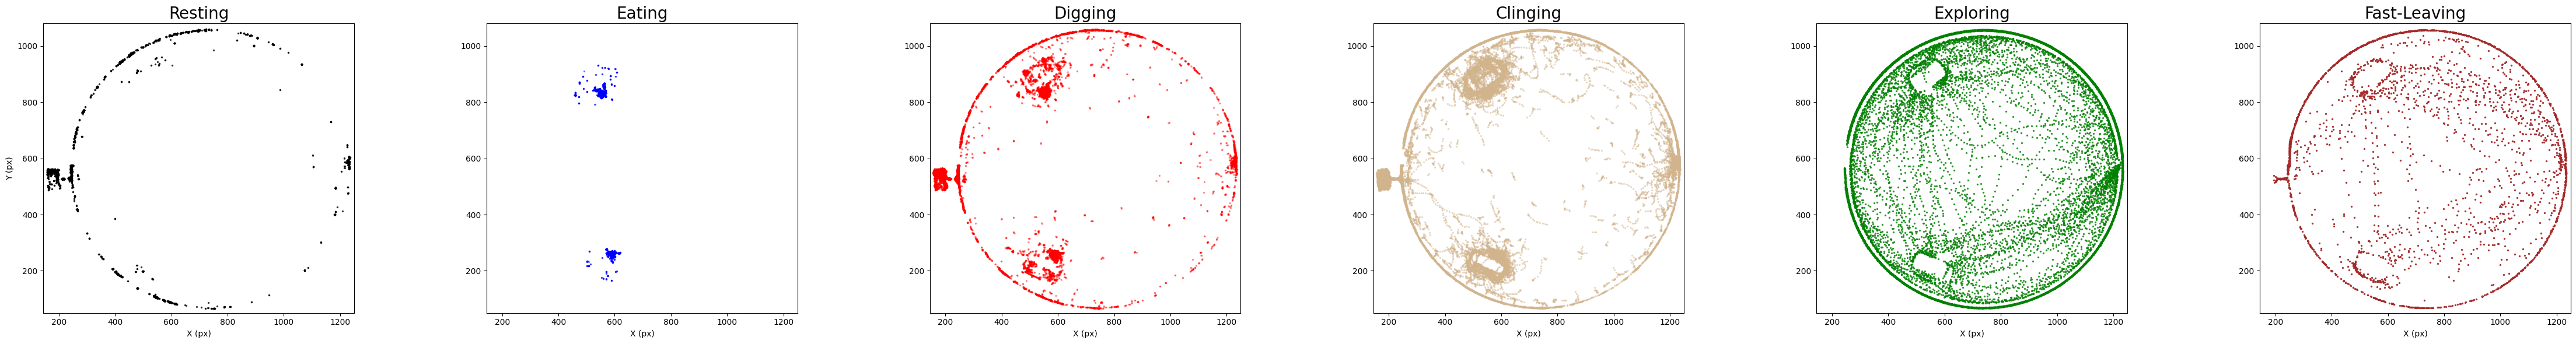

In [8]:
x = mouse_pos.smoothed_position_x.to_numpy()
y = mouse_pos.smoothed_position_y.to_numpy()
states = mouse_pos.states.to_numpy()

fig, axs = plt.subplots(1, n, figsize = (n*8-2,6))
for i in range(n):
    axs[i].scatter(x[states == i], y[states == i], color = color_names[i], s = 2, alpha = alpha[i])
    axs[i].set_xlim(145, 1250)
    axs[i].set_ylim(50, 1080)
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].set_title(state_names[i], fontsize = 20)
    axs[i].set_xlabel('X (px)')
axs[0].set_ylabel('Y (px)')

plt.tight_layout()
plt.show()

### Digging/Eating

In [9]:
def gradient_cmap(colors, nsteps=256, bounds=None):
    """Return a colormap that interpolates between a set of colors.

    Ported from HIPS-LIB plotting functions [https://github.com/HIPS/hips-lib]
    """
    ncolors = len(colors)
    # assert colors.shape[1] == 3
    if bounds is None:
        bounds = np.linspace(0,1,ncolors)


    reds = []
    greens = []
    blues = []
    alphas = []
    for b,c in zip(bounds, colors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1., 1.))

    cdict = {'red': tuple(reds),
             'green': tuple(greens),
             'blue': tuple(blues),
             'alpha': tuple(alphas)}

    cmap = LinearSegmentedColormap('grad_colormap', cdict, nsteps)
    return cmap

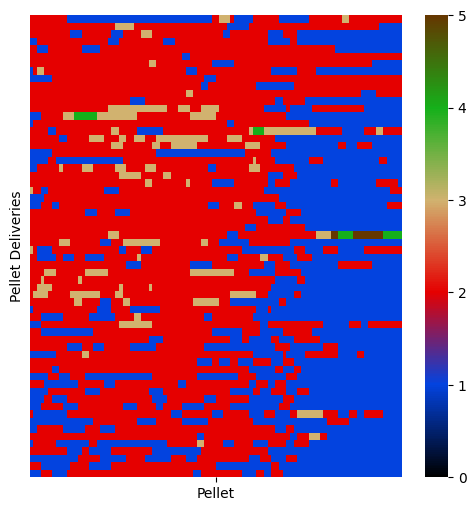

In [10]:
PELLET = pd.read_parquet('FigureData/PELLET.parquet', engine='pyarrow')

Pellets_State = []

for i in range(len(PELLET)):
    trigger = PELLET.index[i]
    
    latest_valid_index = mouse_pos.loc[trigger - pd.Timedelta('6S'):trigger, 'states'].index
    latest_valid_state = mouse_pos.loc[latest_valid_index, ['states']].values.reshape(-1)
    if len(latest_valid_state) >= 50: latest_valid_state  = latest_valid_state[-50:]
    
    next_valid_index = mouse_pos.loc[trigger:trigger + pd.Timedelta('6S'), 'states'].index
    next_valid_state = mouse_pos.loc[next_valid_index, ['states']].values.reshape(-1)
    if len(next_valid_state) >= 50: next_valid_state  = next_valid_state[:50]
    
    state = np.concatenate((latest_valid_state, next_valid_state))
    
    Pellets_State.append(state)


N = 6
colors = sns.xkcd_palette(color_names[0:N])
cmap = gradient_cmap(colors)

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(Pellets_State,cmap=cmap, ax=axs, vmin=0, vmax = N-1, cbar = True)
axs.set_aspect('auto')

axs.set_xticks([50])
axs.set_xticklabels(['Pellet'], rotation = 0)

axs.set_ylabel("Pellet Deliveries")
axs.set_yticks([])

plt.show()

### Exploring(E.) / Fast-Leaving (F.L.)

#### Average Speed and Acceleration

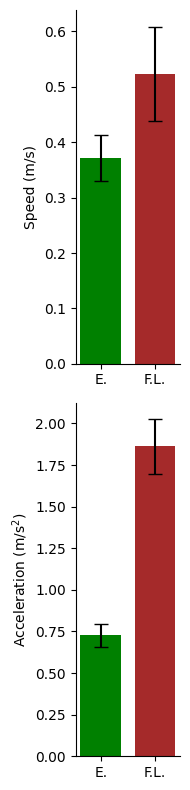

In [33]:
mouse_pos_arena = mouse_pos[mouse_pos['Arena'] == 1]
    
    
explore = mouse_pos_arena[mouse_pos_arena['states'] == 4]
speed_explore, acce_explore = explore.smoothed_speed.to_numpy(), explore.smoothed_acceleration.to_numpy()

leave = mouse_pos_arena[mouse_pos_arena['states'] == 5]
speed_leave, acce_leave = leave.smoothed_speed.to_numpy(), leave.smoothed_acceleration.to_numpy()

mean_speed = np.array([np.mean(speed_explore), np.mean(speed_leave)])
var_speed = np.array([np.std(speed_explore)/np.sqrt(len(speed_explore)), np.std(speed_leave)/np.sqrt(len(speed_leave))])

mean_acce = np.array([np.mean(acce_explore), np.mean(acce_leave)])
var_acce = np.array([np.std(acce_explore)/np.sqrt(len(acce_explore)), np.std(acce_leave)/np.sqrt(len(acce_leave))])

width = 0.15
x_loc = [0,0.2]
fig, axs = plt.subplots(2, 1, figsize = (2, 4*2))
axs[0].bar(x_loc, mean_speed, yerr=var_speed**0.5, width = width, capsize=5, color = ['green','brown'])
axs[1].bar(x_loc, mean_acce, yerr=var_acce**0.5, width = width, capsize=5, color = ['green','brown'])
axs[0].set_xticks(x_loc, ['E.', 'F.L.'])
axs[1].set_xticks(x_loc, ['E.', 'F.L.'])
axs[0].set_ylabel('Speed (m/s)')
axs[1].set_ylabel('Acceleration (m/s$^2$)')

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Average Direction of X-Axis Speed and Acceleration

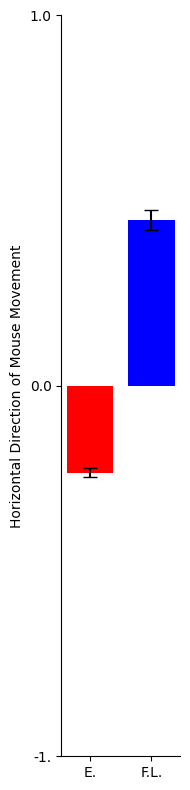

In [31]:
width = 0.15
x_loc = [0,0.2]
fig, axs = plt.subplots(1, 1, figsize = (2, 4*2))

speed_explore_x = explore.smoothed_velocity_x.to_numpy()
speed_leave_x = leave.smoothed_velocity_x.to_numpy()
speed_explore_dir = np.where(speed_explore_x < 0, -1, 0) + np.where(speed_explore_x > 0, 1, 0)
speed_leave_dir = np.where(speed_leave_x < 0, -1, 0) + np.where(speed_leave_x > 0, 1, 0)
mean_speed = np.array([np.mean(speed_explore_dir), np.mean(speed_leave_dir)])
var_speed = np.array([np.std(speed_explore_dir)/np.sqrt(len(speed_explore_dir)), np.std(speed_explore_dir)/np.sqrt(len(speed_leave_dir))])
axs.bar(x_loc, mean_speed, yerr=var_speed, width = width, capsize=5, color = ['red', 'blue'])
axs.set_ylabel('Horizontal Direction of Mouse Movement')

axs.set_xticks(x_loc, ['E.', 'F.L.'])
axs.set_yticks(np.array([-1,0, 1]), ['-1.','0.0', '1.0'])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)


plt.tight_layout()
plt.show()

#1.0: Right
#-1.0: Left

#### Position Map of Each State, Coloured by Direction of Speed

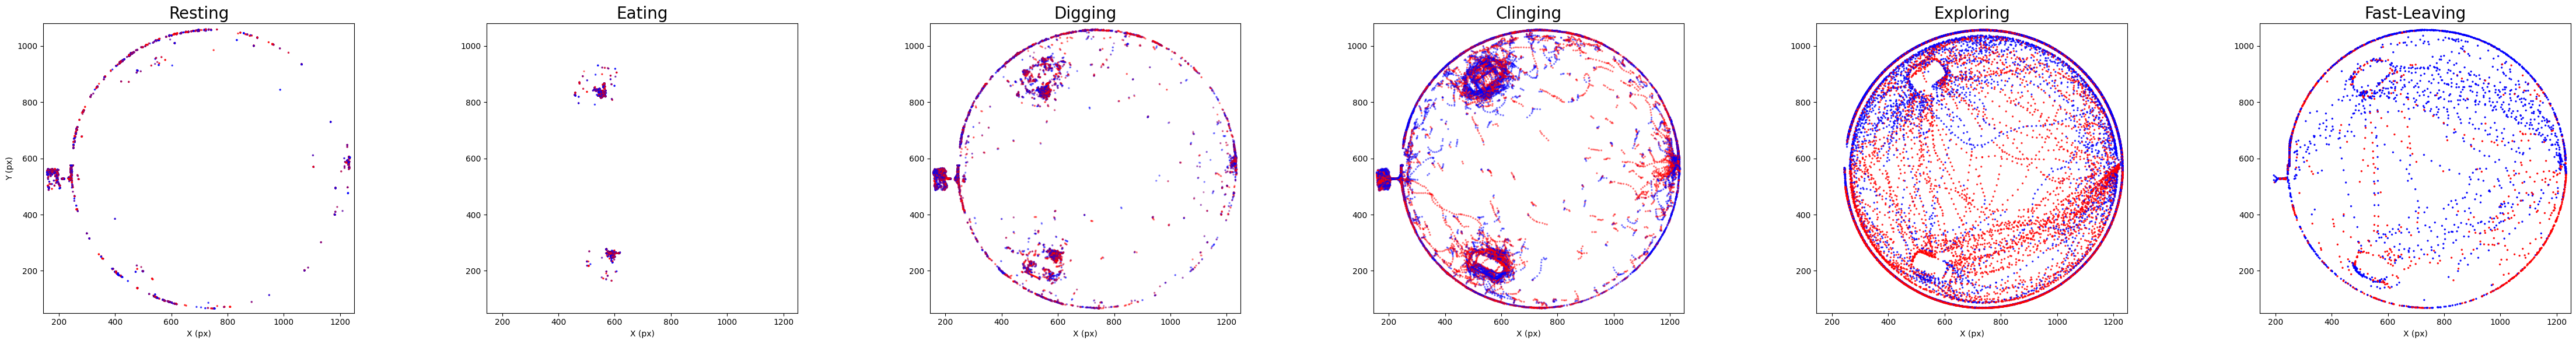

In [32]:
x = mouse_pos.smoothed_position_x.to_numpy()
y = mouse_pos.smoothed_position_y.to_numpy()
states = mouse_pos.states.to_numpy()

X_vel = mouse_pos.smoothed_velocity_x.to_numpy()
flag = X_vel > 0

fig, axs = plt.subplots(1, n, figsize = (n*8-2,6))
for i in range(n):
    x_vel_dir = flag[states == i]
    colors = ['blue' if j else 'red' for j in x_vel_dir]
    axs[i].scatter(x[states == i], y[states == i], color = colors, s = 2, alpha = alpha[i])
    axs[i].set_xlim(145, 1250)
    axs[i].set_ylim(50, 1080)
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].set_title(state_names[i], fontsize = 20)
    axs[i].set_xlabel('X (px)')
axs[0].set_ylabel('Y (px)')

plt.tight_layout()
plt.show()